customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   o

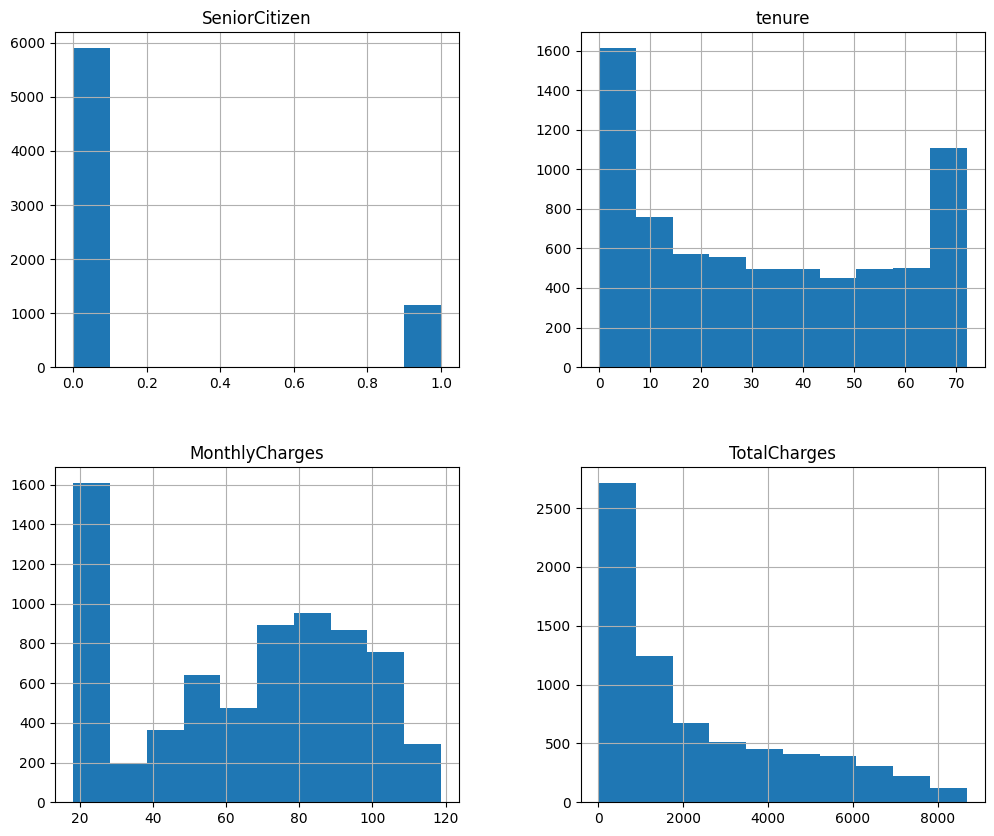

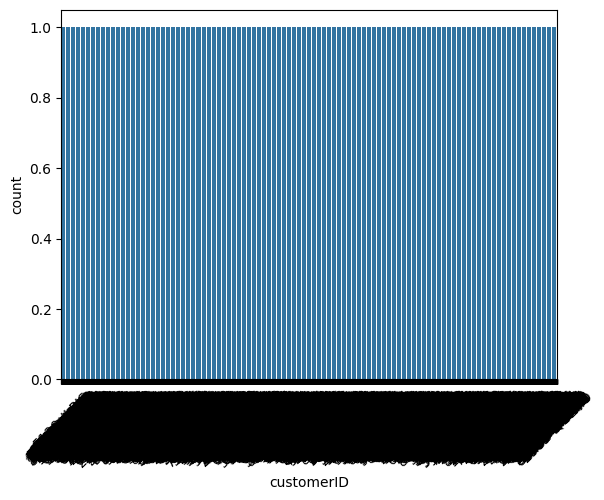

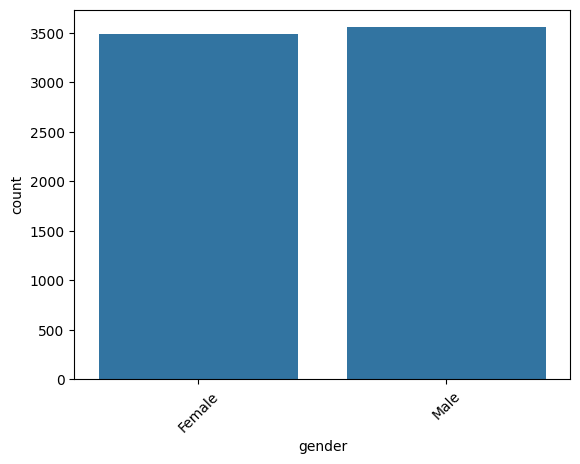

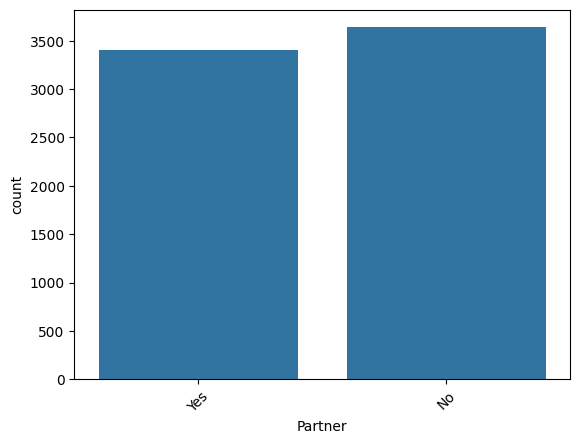

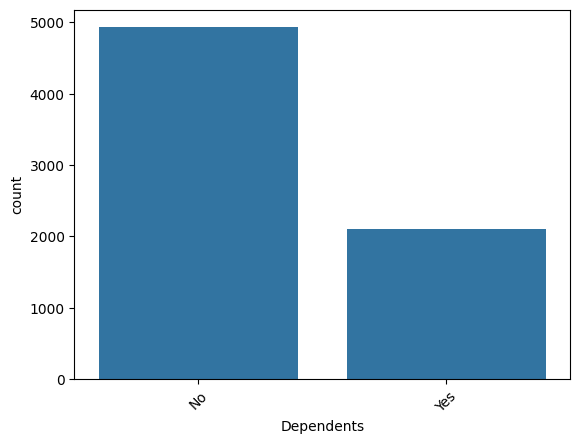

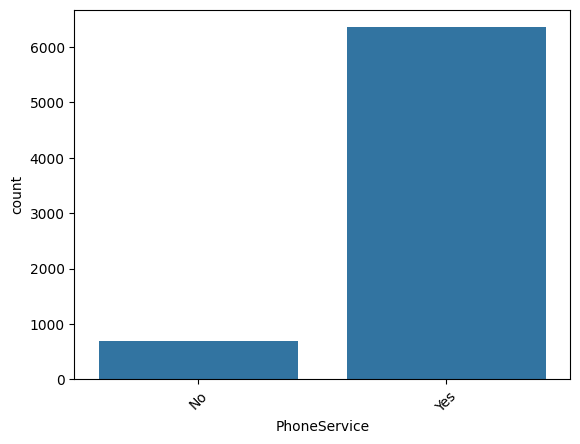

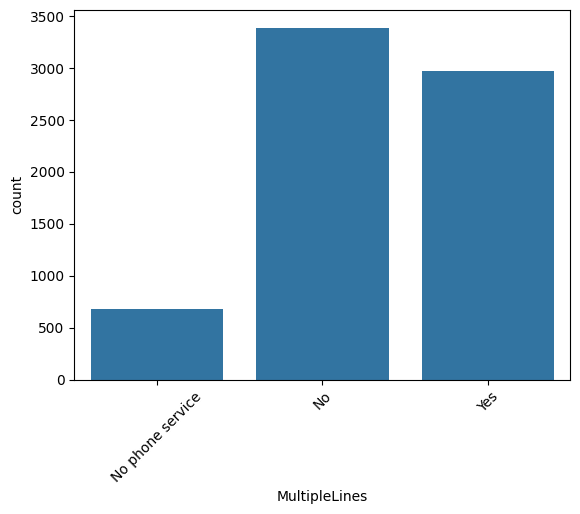

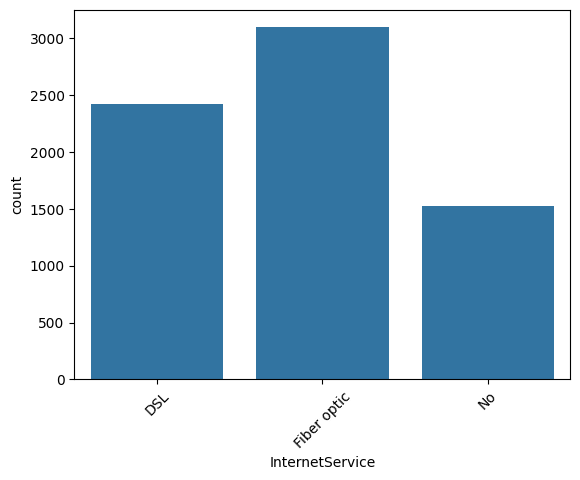

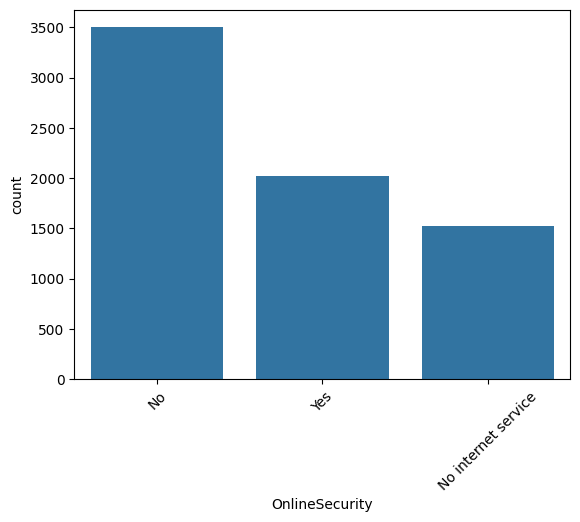

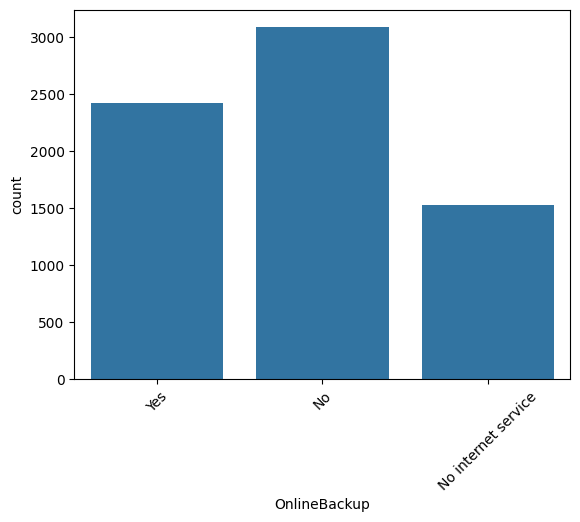

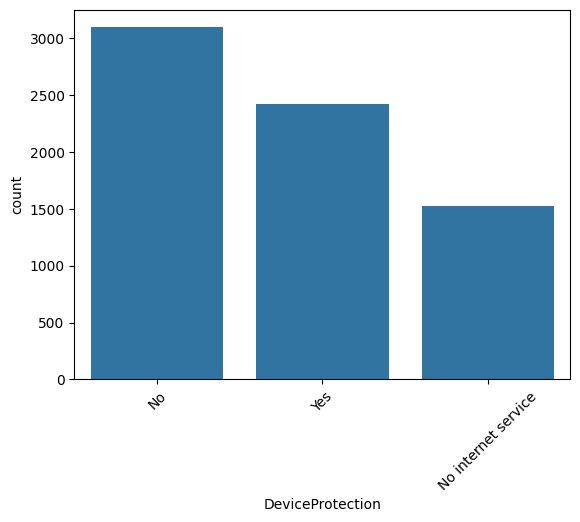

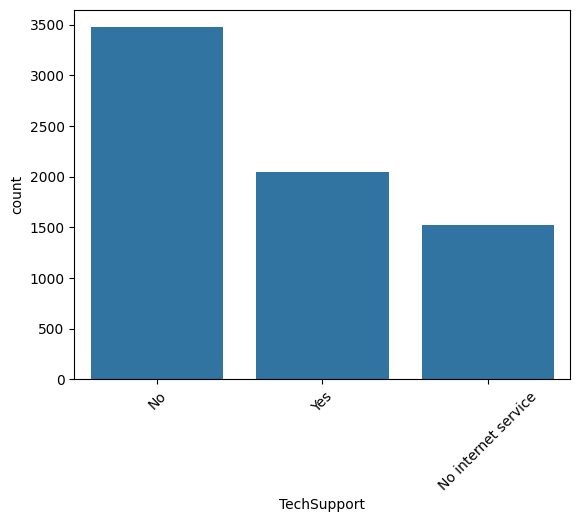

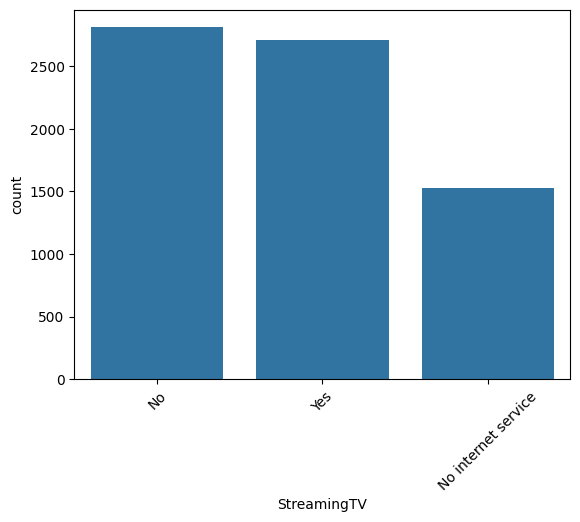

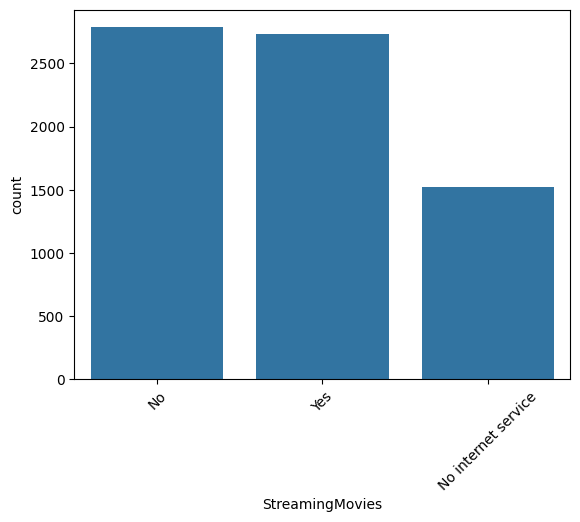

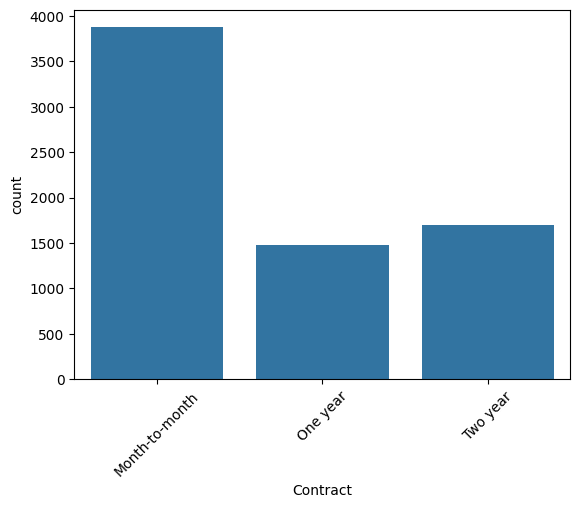

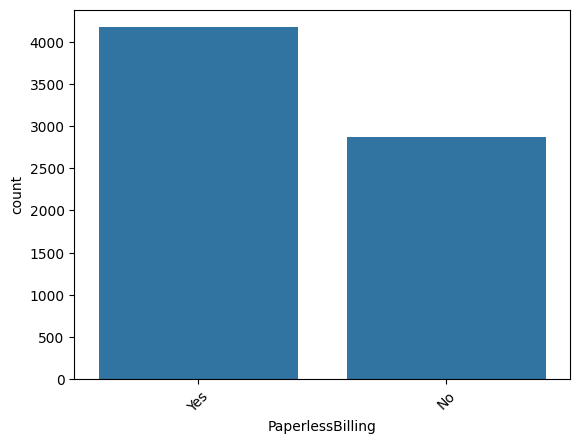

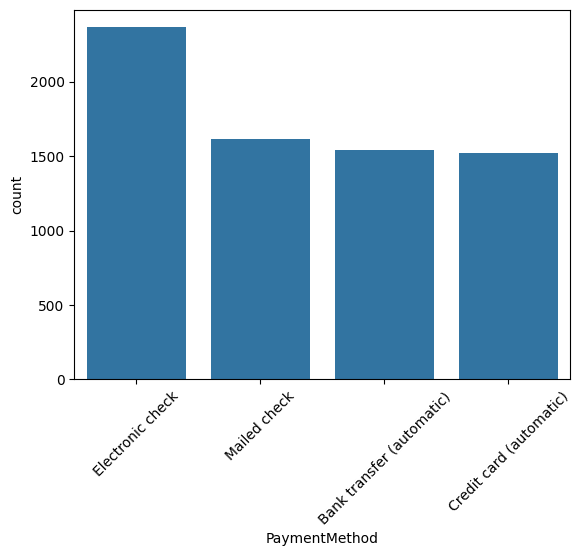

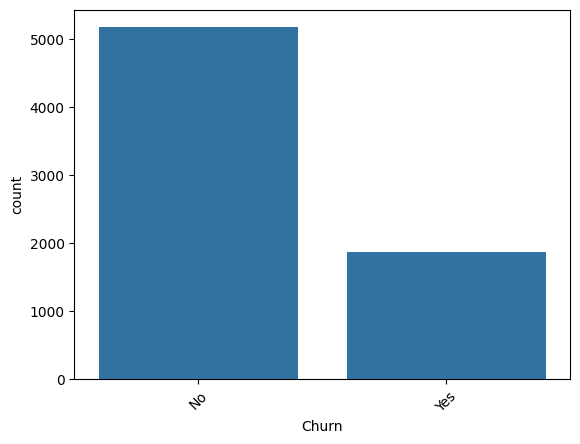

ValueError: Could not interpret value `Tenure` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [1]:
# Install Libraries (If needed - Colab usually has these)
# !pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample  # For handling class imbalance (if needed)

# 1. Data Loading
try:
    df = pd.read_csv("telco_churn.csv")  # Or the path to your dataset
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure the file is in the correct location or provide the correct path.")
    # Instead of exit(), raise the exception to allow handling in notebook environment
    raise

# The rest of the code remains unchanged...

# 2. Data Cleaning
## Missing Values
print(df.isnull().sum())   # Check for missing values

# Convert 'TotalCharges' to numeric, handling potential errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# 'errors='coerce'' will turn any non-numeric values into NaN (missing)

# Now fill the NaN values in 'TotalCharges' with the median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())  # Corrected line
# Document your strategy in a markdown cell

## Duplicates
print(df.duplicated().sum())  # Check for duplicates
df = df.drop_duplicates()  # Remove duplicates
# Document

## Data Types
print(df.info())  # Check data types
# Convert TotalCharges to numeric (handle errors)
# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Already done
# Handle newly introduced missing values from conversion
# Document

# 3. Exploratory Data Analysis (EDA)
## Univariate Analysis
# Histograms for numerical features
df.hist(figsize=(12, 10))
plt.show()
# Countplots for categorical features
for col in df.select_dtypes(include='object').columns:
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.show()
# Boxplots for numerical features (outlier detection)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Churn', y='Tenure')
plt.show()
# Document insights in markdown cells

## Bivariate/Multivariate Analysis
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()
# Scatterplots
sns.scatterplot(data=df, x='Tenure', y='MonthlyCharges', hue='Churn')
plt.show()
# Grouped bar plots
sns.catplot(data=df, x='Contract', kind='count', hue='Churn', col='InternetService', aspect=0.8, height=4)
plt.show()
# Document insights

# 4. Feature Engineering
## Create New Features
df['AvgMonthlyUsage'] = df['TotalCharges'] / df['Tenure']
df['HasMultipleServices'] = ((df['PhoneService'] == 'Yes') & (df['InternetService'] == 'Yes') & (df['OnlineSecurity'] == 'Yes')).astype(int)
# Document why you created these

## Binning
df['Tenure_Group'] = pd.qcut(df['Tenure'], q=4, labels=['0-1 Year', '1-2 Years', '2-5 Years', '5+ Years'])
# Document your binning strategy

## One-Hot Encode Tenure Group (and other categorical features if needed after binning)
df = pd.get_dummies(df, columns=['Tenure_Group'], drop_first=True)

## Preprocessing for Modeling
# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).drop(columns=['Churn']).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Create transformers for preprocessing
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')  # handle_unknown='ignore' is important!

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep remaining columns (like engineered features)
)

# 5. Model Building
## Prepare Data
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)  # Ensure y is numeric

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Stratify!

## Model 1: Logistic Regression
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])  # solver important for smaller datasets
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

## Model 2: Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

## Model Evaluation
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"--- {model_name} ---")
    print(f"    Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"    Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"    Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"    F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"    ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_pred_proba):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, 'Logistic Regression')
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, 'Random Forest')

## Feature Importance (Random Forest)
feature_importances = pipeline_rf.named_steps['classifier'].feature_importances_
feature_names = X_train.columns  # Or get feature names from preprocessor

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 6. Conclusion
# Summarize your findings, compare models, and discuss limitations and future work